In [1]:
!git clone -b mittra https://github.com/tirthankar95/CSCI_7000_FinalProject.git
!sudo apt install rar

Cloning into 'CSCI_7000_FinalProject'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 651 (delta 72), reused 141 (delta 48), pack-reused 477
Receiving objects: 100% (651/651), 25.51 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (277/277), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 0s (1,400 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable 

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed,SimpleRNN,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import re

In [4]:
%cd /content/CSCI_7000_FinalProject/

/content/CSCI_7000_FinalProject


In [5]:
from HandCraftedEnv.mylava_env import *
from HandCraftedEnv.mydoorkey_env import *

In [14]:
def plotProgress(reward_plot,xlabel,ylabel,title):
    plt.plot(reward_plot)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(f'{ylabel}.png')
    plt.show()

def create():
    global num_actions,frameForPrediction
    input=Input(shape=(frameForPrediction,25)) # (4,1,5,5) ~ my grid returns (1,2*visibility+1,2*visibility+1)
    temp=LSTM(units=100,return_sequences=False)(input)
    temp=Dense(units=100, activation='relu')(temp)
    temp=Dense(units=50, activation='relu')(temp)
    temp=Dense(units=10, activation='relu')(temp)
    output=Dense(units=num_actions,activation='linear')(temp)
    model=Model(input,output)
    return model

In [16]:
def trainAgentInEnv(env):
  global model,model_target,loss_function,optimizer,reward_plot,action_history,state_history,state_next_history,rewards_history,noOfUpdates
  # Configuration paramaters for the whole setup
  seed = 42
  gamma = 0.99  # Discount factor for past rewards
  epsilon = 1.0  # Epsilon greedy parameter
  epsilon_min = 0.1  # Minimum epsilon greedy parameter
  epsilon_max = 1.0  # Maximum epsilon greedy parameter
  epsilon_interval = (
      epsilon_max - epsilon_min
  )  # Rate at which to reduce chance of random action being taken
  batch_size = 128  # Size of batch taken from replay buffer
  max_steps_per_episode = 1000
  episode_reward_history=[]

  running_reward = 0
  frame_count = 0
  # Number of frames to take random action and observe output
  epsilon_random_frames = 10000
  # Number of frames for exploration
  epsilon_greedy_frames = 10000.0
  # Maximum replay length
  # Note: The Deepmind paper suggests 1000000 however this causes memory issues
  max_memory_length = 100000
  # Train the model after 4 actions
  update_after_actions = 10
  # How often to update the target network
  update_target_network = 1000
  # Using huber loss for stability
  # We are taking 4 frames in our LSTM
  frame_offset=frameForPrediction-1
  noOfEpisodes=1000 #beast 100000

  dummy_state=[[[-1 for i in range(5)] for j in range(5)]] #2*visibility+1=5
  dummy_action=-1
  dummy_reward=-1
  dummy=-1
  # Run this multiple times. (1000)
  state, reward, done, _ = env.reset_m()
  for _ in tqdm(range(noOfEpisodes)):  # Run until solved
      state, reward, done, _ = env.reset_prev()
      episode_reward = 0
      for i in range(frame_offset):
        state_history.append(dummy_state)
        state_next_history.append(dummy_state)
        rewards_history.append(dummy_reward)
        action_history.append(dummy_action)
        done_history.append(dummy)
      for timestep in range(1, max_steps_per_episode):
          # env.render(); Adding this line would show the attempts
          # of the agent in a pop up window.
          frame_count += 1
          # Use epsilon-greedy for exploration
          if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
              # Take random action
              action = np.random.choice(num_actions)
          else:
              # Predict action Q-values
              # From environment state
              state_numpy = np.array(state_history[-frameForPrediction:]).reshape(frameForPrediction,25)
              state_numpy = np.array([state_numpy])
              action_probs = model(state_numpy, training=False)
              # Take best action
              action = np.argmax(action_probs[0])

          # Decay probability of taking random action
          epsilon -= epsilon_interval / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min)

          # Apply the sampled action in our environment
          state_next, reward, done, _ = env.step_m(action)
          episode_reward += reward

          # Save actions and states in replay buffer
          state_history.append(state)
          state_next_history.append(state_next)
          action_history.append(action)
          done_history.append(done)
          rewards_history.append(reward)
          state = state_next

          # Update every fourth frame and once batch size is over 32
          if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
              # Get indices of samples for replay buffers
              noOfUpdates-=1
              if noOfUpdates==0:
                indices = np.random.choice(range(len(done_history)-frame_offset), size=len(done_history))+frame_offset
                noOfUpdates=10000
              else:
                indices = np.random.choice(range(len(done_history)-frame_offset), size=batch_size)+frame_offset
              # Using list comprehension to sample from replay buffer
              state_sample = np.array([ np.array(state_history[i-frame_offset:i+1]).reshape(frameForPrediction,25) for i in indices])
              state_next_sample = np.array([ np.array(state_next_history[i-frame_offset:i+1]).reshape(frameForPrediction,25) for i in indices])
              rewards_sample = [rewards_history[i] for i in indices]
              action_sample = [action_history[i] for i in indices]
              # Build the updated Q-values for the sampled future states
              # Use the target model for stability
              future_rewards = model_target.predict(state_next_sample,verbose=False)
              # Q value = reward + discount factor * expected future reward
              updated_q_values = rewards_sample + gamma * np.max(future_rewards, axis=1)
              updated_q_values = updated_q_values.astype('float32')
              # Create a mask so we only calculate loss on the updated Q-values
              masks = tf.one_hot(action_sample, num_actions)
              with tf.GradientTape() as tape:    
                  q_values = model(state_sample)
                  # Apply the masks to the Q-values to get the Q-value for action taken
                  q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                  loss = loss_function(updated_q_values,q_action)
              # Backpropagation
              grads = tape.gradient(loss, model.trainable_variables)
              optimizer.apply_gradients(zip(grads, model.trainable_variables))
              

          if frame_count % update_target_network == 0:
              # update the the target network with new weights
              model_target.set_weights(model.get_weights())
              # Log details
              template = "running reward: {:.2f} at episode {}, frame count {}"
              print(template.format(running_reward, _, frame_count))

          # Limit the state and reward history
          if len(rewards_history) > max_memory_length:
              del rewards_history[:1]
              del state_history[:1]
              del state_next_history[:1]
              del action_history[:1]
              del done_history[:1]
          if done:
              break
      # Update running reward to check condition for solving
      episode_reward_history.append(episode_reward)
      running_reward = np.mean(episode_reward_history)
      reward_plot.append(episode_reward)
      episode_steps_plot.append(timestep)

In [27]:
!unrar -r x HandCraftedEnv/LAVA_RESULTS/Expert_l.ml.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from HandCraftedEnv/LAVA_RESULTS/Expert_l.ml.rar

Creating    Expert_l.ml                                               OK
Extracting  Expert_l.ml/saved_model.pb                                     6%  OK 
Creating    Expert_l.ml/variables                                     OK
Extracting  Expert_l.ml/variables/variables.data-00000-of-00001           99%  OK 
Extracting  Expert_l.ml/variables/variables.index                         99%  OK 
Extracting  Expert_l.ml/keras_metadata.pb                                 99%  OK 
Creating    Expert_l.ml/assets                                        OK
All OK


In [28]:
!unrar -r x HandCraftedEnv/DOOR_KEY_RESULTS/Expert_dk.ml.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from HandCraftedEnv/DOOR_KEY_RESULTS/Expert_dk.ml.rar

Creating    Expert_dk.ml                                              OK
Extracting  Expert_dk.ml/saved_model.pb                                    6%  OK 
Extracting  Expert_dk.ml/keras_metadata.pb                                 7%  OK 
Creating    Expert_dk.ml/variables                                    OK
Extracting  Expert_dk.ml/variables/variables.index                         7%  OK 
Extracting  Expert_dk.ml/variables/variables.data-00000-of-00001          99%  OK 
Creating    Expert_dk.ml/assets                                       OK
All OK


 13%|█▎        | 128/1000 [00:11<00:58, 14.91it/s]

running reward: -14.72 at episode (3, 5), frame count 1000


 26%|██▌       | 262/1000 [00:23<01:04, 11.50it/s]

running reward: -13.18 at episode (5, 3), frame count 2000


 40%|███▉      | 397/1000 [00:36<00:54, 11.03it/s]

running reward: -13.14 at episode (5, 4), frame count 3000


 50%|█████     | 501/1000 [00:47<00:41, 11.95it/s]

running reward: -13.52 at episode (4, 5), frame count 4000


 65%|██████▍   | 649/1000 [01:06<00:27, 12.80it/s]

running reward: -13.19 at episode (4, 4), frame count 5000


 76%|███████▌  | 759/1000 [01:30<00:33,  7.28it/s]

running reward: -13.11 at episode (3, 5), frame count 6000


 87%|████████▋ | 870/1000 [01:45<00:19,  6.62it/s]

running reward: -13.18 at episode (2, 4), frame count 7000


100%|██████████| 1000/1000 [01:55<00:00,  8.67it/s]


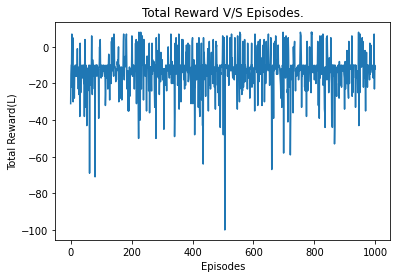

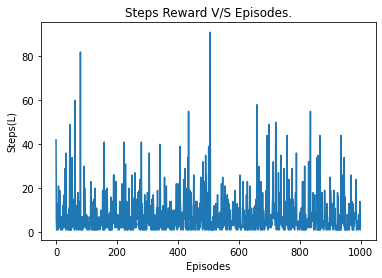


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Creating archive Expert_l.ml.rar

Adding    Expert_l.ml/keras_metadata.pb                                    1%  OK 
Adding    Expert_l.ml/saved_model.pb                                      73%  OK 
Adding    Expert_l.ml/variables/variables.index                           73%  OK 
Adding    Expert_l.ml/variables/variables.data-00000-of-00001             99%  OK 
Adding    Expert_l.ml/assets                                               OK 
Adding    Expert_l.ml/variables                                            OK 
Done


In [30]:
num_actions=5
noOfUpdates=10000 #after 10000 frames do a full
frameForPrediction=4

action_history = []
state_history = []
state_next_history = []
rewards_history = []
reward_plot = []
episode_steps_plot = []
done_history = []

env1 = lava()
model=create()
model_target=create()

loss_function = keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.RMSprop()

def loadCheckPoints():
  global model,model_target,reward_plot,episode_steps_plot 
  model.load_weights('Expert_l.ml')

def saveCheckPoints():
  # Save checkpoints. 
  file=open('RewardsL.txt','w')
  file.write(str(reward_plot))
  file.close()
  file=open('EpisodesL.txt','w')
  file.write(str(episode_steps_plot))
  file.close()
  model.save('Expert_l.ml')
  plotProgress(reward_plot,'Episodes','Total Reward(L)','Total Reward V/S Episodes.')
  print()
  plotProgress(episode_steps_plot,'Episodes','Steps(L)','Steps Reward V/S Episodes.')

loadCheckPoints()
trainAgentInEnv(env1)
# for gce.
saveCheckPoints()
!rar -r a Expert_l.ml.rar Expert_l.ml/

In [31]:
state, reward, done, _ = env1.reset_prev()
frame_offset=frameForPrediction-1

state_historyP=[ state for i in range(frameForPrediction)]

while not done:
  state_numpyP = np.array(state_historyP[-frameForPrediction:]).reshape(frameForPrediction,25)
  state_numpyP = np.array([state_numpyP])
  action_probs = model(state_numpyP, training=False)
  action = np.argmax(action_probs[0])
  env1.printEnv()
  print(action)
  state, reward, done, _ = env1.step_m(action)
  del state_historyP[:1]
  state_historyP.append(state)



8 0 8 4 
0 0 0 0 
0 0 0 0 
0 0 0 32 



3


8 0 8 0 
0 0 0 4 
0 0 0 0 
0 0 0 32 



3


8 0 8 0 
0 0 0 0 
0 0 0 4 
0 0 0 32 



3


  1%|          | 8/1000 [00:10<24:50,  1.50s/it]

running reward: -110.88 at episode (2, 5), frame count 1000


  1%|          | 11/1000 [00:15<27:43,  1.68s/it]

running reward: -109.64 at episode (4, 2), frame count 2000


  2%|▏         | 21/1000 [00:34<18:58,  1.16s/it]

running reward: -133.15 at episode (3, 2), frame count 3000


  2%|▎         | 25/1000 [00:41<24:42,  1.52s/it]

running reward: -131.48 at episode (2, 5), frame count 4000


  3%|▎         | 32/1000 [00:57<27:44,  1.72s/it]

running reward: -144.50 at episode (4, 3), frame count 5000


  4%|▍         | 41/1000 [01:09<18:29,  1.16s/it]

running reward: -138.38 at episode (5, 3), frame count 6000


  5%|▌         | 51/1000 [01:19<22:26,  1.42s/it]

running reward: -124.47 at episode (5, 4), frame count 7000


  6%|▌         | 59/1000 [01:31<28:14,  1.80s/it]

running reward: -124.24 at episode (5, 5), frame count 8000


  7%|▋         | 66/1000 [01:43<22:04,  1.42s/it]

running reward: -126.11 at episode (4, 3), frame count 9000


  7%|▋         | 71/1000 [01:53<29:16,  1.89s/it]

running reward: -129.07 at episode (4, 3), frame count 10000


  8%|▊         | 80/1000 [02:14<32:13,  2.10s/it]

running reward: -126.40 at episode (4, 2), frame count 11000


 10%|█         | 104/1000 [02:33<14:10,  1.05it/s]

running reward: -103.62 at episode (3, 2), frame count 12000


 11%|█▏        | 114/1000 [02:54<31:07,  2.11s/it]

running reward: -102.57 at episode (4, 2), frame count 13000


 14%|█▎        | 136/1000 [03:15<06:54,  2.09it/s]

running reward: -92.74 at episode (3, 2), frame count 14000


 16%|█▌        | 158/1000 [03:37<19:58,  1.42s/it]

running reward: -83.91 at episode (4, 2), frame count 15000


 17%|█▋        | 167/1000 [03:56<27:48,  2.00s/it]

running reward: -84.54 at episode (4, 2), frame count 16000


 18%|█▊        | 181/1000 [04:17<18:17,  1.34s/it]

running reward: -82.96 at episode (3, 4), frame count 17000


 20%|█▉        | 197/1000 [04:36<14:54,  1.11s/it]

running reward: -80.25 at episode (3, 2), frame count 18000


 22%|██▏       | 221/1000 [04:57<16:48,  1.29s/it]

running reward: -74.93 at episode (4, 2), frame count 19000


 24%|██▍       | 243/1000 [05:17<10:43,  1.18it/s]

running reward: -71.34 at episode (2, 4), frame count 20000


 26%|██▌       | 256/1000 [05:35<12:16,  1.01it/s]

running reward: -70.74 at episode (3, 2), frame count 21000


 27%|██▋       | 273/1000 [05:56<16:30,  1.36s/it]

running reward: -69.23 at episode (2, 2), frame count 22000


 29%|██▉       | 291/1000 [06:19<12:36,  1.07s/it]

running reward: -68.16 at episode (5, 3), frame count 23000


 30%|██▉       | 298/1000 [06:39<41:00,  3.51s/it]

running reward: -69.56 at episode (2, 5), frame count 24000


 32%|███▏      | 315/1000 [07:00<12:14,  1.07s/it]

running reward: -68.61 at episode (4, 4), frame count 25000


 34%|███▍      | 341/1000 [07:19<06:14,  1.76it/s]

running reward: -65.19 at episode (3, 2), frame count 26000


 35%|███▌      | 353/1000 [07:38<14:43,  1.37s/it]

running reward: -65.29 at episode (2, 2), frame count 27000


 36%|███▋      | 365/1000 [08:00<24:32,  2.32s/it]

running reward: -65.71 at episode (3, 3), frame count 28000


 40%|███▉      | 395/1000 [08:23<06:02,  1.67it/s]

running reward: -62.61 at episode (3, 2), frame count 29000


 42%|████▏     | 415/1000 [08:43<06:11,  1.57it/s]

running reward: -61.20 at episode (3, 2), frame count 30000


 44%|████▍     | 443/1000 [09:04<07:06,  1.31it/s]

running reward: -59.00 at episode (2, 5), frame count 31000


 46%|████▌     | 458/1000 [09:24<08:46,  1.03it/s]

running reward: -58.68 at episode (3, 2), frame count 32000


 48%|████▊     | 481/1000 [09:45<04:20,  1.99it/s]

running reward: -57.57 at episode (2, 2), frame count 33000


 51%|█████     | 507/1000 [10:06<04:08,  1.98it/s]

running reward: -56.03 at episode (3, 2), frame count 34000


 52%|█████▏    | 517/1000 [10:27<25:21,  3.15s/it]

running reward: -56.72 at episode (2, 5), frame count 35000


 53%|█████▎    | 533/1000 [10:45<05:19,  1.46it/s]

running reward: -56.36 at episode (4, 2), frame count 36000


 54%|█████▍    | 541/1000 [11:02<20:04,  2.62s/it]

running reward: -56.94 at episode (3, 2), frame count 37000


 56%|█████▌    | 561/1000 [11:27<03:52,  1.89it/s]

running reward: -56.66 at episode (2, 2), frame count 38000


 59%|█████▊    | 586/1000 [11:48<05:40,  1.21it/s]

running reward: -55.56 at episode (2, 2), frame count 39000


 61%|██████    | 606/1000 [12:09<05:24,  1.21it/s]

running reward: -55.00 at episode (4, 2), frame count 40000


 61%|██████▏   | 613/1000 [12:28<13:26,  2.08s/it]

running reward: -55.77 at episode (2, 2), frame count 41000


 64%|██████▎   | 635/1000 [12:50<04:51,  1.25it/s]

running reward: -55.09 at episode (2, 2), frame count 42000


 65%|██████▌   | 650/1000 [13:11<10:34,  1.81s/it]

running reward: -55.10 at episode (3, 2), frame count 43000


 65%|██████▌   | 654/1000 [13:31<27:14,  4.72s/it]

running reward: -56.24 at episode (2, 5), frame count 44000


 66%|██████▌   | 655/1000 [13:53<56:13,  9.78s/it]

running reward: -57.53 at episode (2, 5), frame count 45000


 66%|██████▌   | 659/1000 [14:12<34:37,  6.09s/it]

running reward: -58.55 at episode (3, 5), frame count 46000


 66%|██████▋   | 665/1000 [14:35<21:33,  3.86s/it]

running reward: -59.61 at episode (3, 2), frame count 47000


 68%|██████▊   | 675/1000 [14:57<09:44,  1.80s/it]

running reward: -60.12 at episode (3, 2), frame count 48000


 69%|██████▉   | 689/1000 [15:16<06:26,  1.24s/it]

running reward: -60.09 at episode (4, 2), frame count 49000


 71%|███████▏  | 714/1000 [15:36<03:38,  1.31it/s]

running reward: -58.95 at episode (4, 2), frame count 50000


 73%|███████▎  | 730/1000 [15:59<05:26,  1.21s/it]

running reward: -58.86 at episode (2, 2), frame count 51000


 75%|███████▍  | 746/1000 [16:19<06:00,  1.42s/it]

running reward: -58.67 at episode (2, 2), frame count 52000


 77%|███████▋  | 769/1000 [16:40<03:15,  1.18it/s]

running reward: -57.86 at episode (2, 2), frame count 53000


 78%|███████▊  | 783/1000 [17:02<04:13,  1.17s/it]

running reward: -58.03 at episode (3, 2), frame count 54000


 80%|████████  | 803/1000 [17:22<03:25,  1.04s/it]

running reward: -57.48 at episode (4, 2), frame count 55000


 82%|████████▏ | 824/1000 [17:42<01:37,  1.81it/s]

running reward: -56.91 at episode (2, 2), frame count 56000


 84%|████████▍ | 842/1000 [18:04<03:03,  1.16s/it]

running reward: -56.66 at episode (3, 2), frame count 57000


 86%|████████▌ | 862/1000 [18:25<02:22,  1.03s/it]

running reward: -56.28 at episode (3, 2), frame count 58000


 88%|████████▊ | 879/1000 [18:46<02:12,  1.10s/it]

running reward: -56.13 at episode (2, 2), frame count 59000


 91%|█████████ | 906/1000 [19:09<01:34,  1.00s/it]

running reward: -55.22 at episode (3, 4), frame count 60000


 92%|█████████▏| 924/1000 [19:30<01:27,  1.15s/it]

running reward: -55.02 at episode (3, 2), frame count 61000


 93%|█████████▎| 932/1000 [19:51<02:08,  1.90s/it]

running reward: -55.49 at episode (3, 2), frame count 62000


 95%|█████████▍| 946/1000 [20:13<01:31,  1.69s/it]

running reward: -55.56 at episode (4, 2), frame count 63000


 96%|█████████▌| 962/1000 [20:34<00:47,  1.24s/it]

running reward: -55.53 at episode (2, 2), frame count 64000


 99%|█████████▊| 987/1000 [20:54<00:10,  1.28it/s]

running reward: -54.81 at episode (3, 2), frame count 65000


100%|██████████| 1000/1000 [21:13<00:00,  1.27s/it]


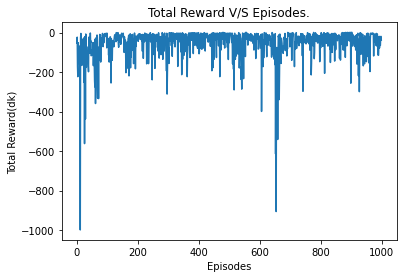

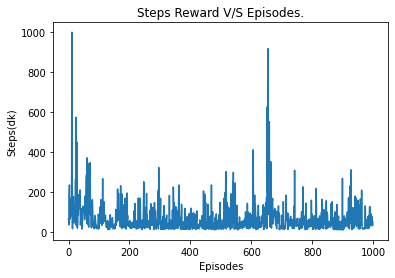


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Updating archive Expert_l.ml.rar

Updating  Expert_l.ml/keras_metadata.pb                                    1%  OK 
Updating  Expert_l.ml/saved_model.pb                                      73%  OK 
Updating  Expert_l.ml/variables/variables.index                           73%  OK 
Updating  Expert_l.ml/variables/variables.data-00000-of-00001             99%  OK 
Updating  Expert_l.ml/assets                                               OK 
Updating  Expert_l.ml/variables                                            OK 
Done


In [32]:
num_actions=5
noOfUpdates=10000 #after 10000 frames do a full
frame_count = 0
epsilon = 1.0  # Epsilon greedy parameter

action_history = []
state_history = []
state_next_history = []
rewards_history = []
reward_plot = []
episode_steps_plot = []
done_history = []

env2 = doorkey()
model=create()
model_target=create()

loss_function = keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.RMSprop()

def loadCheckPoints():
  global model,model_target,reward_plot,episode_steps_plot 
  model.load_weights('Expert_dk.ml')

def saveCheckPoints():
  # Save checkpoints. 
  file=open('Rewardsdk.txt','w')
  file.write(str(reward_plot))
  file.close()
  file=open('Episodesdk.txt','w')
  file.write(str(episode_steps_plot))
  file.close()
  model.save('Expert_dk.ml')
  plotProgress(reward_plot,'Episodes','Total Reward(dk)','Total Reward V/S Episodes.')
  print()
  plotProgress(episode_steps_plot,'Episodes','Steps(dk)','Steps Reward V/S Episodes.')


loadCheckPoints()
trainAgentInEnv(env2)
# for gce.
saveCheckPoints()
!rar -r a Expert_l.ml.rar Expert_l.ml/

In [33]:
state, reward, done, _ = env2.reset_prev()
frame_offset=frameForPrediction-1

state_historyP=[ state for i in range(frameForPrediction)]

while not done:
  state_numpyP = np.array(state_historyP[-frameForPrediction:]).reshape(frameForPrediction,25)
  state_numpyP = np.array([state_numpyP])
  action_probs = model(state_numpyP, training=False)
  action = np.argmax(action_probs[0])
  env2.printEnv()
  print(action)
  state, reward, done, _ = env2.step_m(action)
  del state_historyP[:1]
  state_historyP.append(state)



0 0 4 0 
1 0 0 0 
0 0 2 0 
0 0 0 0 



0


0 4 0 0 
1 0 0 0 
0 0 2 0 
0 0 0 0 



0


4 0 0 0 
1 0 0 0 
0 0 2 0 
0 0 0 0 



3


0 0 0 0 
5 0 0 0 
0 0 2 0 
0 0 0 0 



0


0 0 0 0 
5 0 0 0 
0 0 2 0 
0 0 0 0 



4


0 0 0 0 
5 0 0 0 
0 0 2 0 
0 0 0 0 



1


0 0 0 0 
0 5 0 0 
0 0 2 0 
0 0 0 0 



1


0 0 0 0 
0 0 5 0 
0 0 2 0 
0 0 0 0 



3


In [65]:
from HandCraftedEnv.mymixed_env import *

In [127]:
#Create a mixed env.
mixedGrid=[[0,0,4,0],[1,0,0,0],[0,0,2,0],[0,0,0,0]] 
env3=mixedEnv()
env3.reset(mixedGrid)
env3.printEnv()



0 0 4 0 
1 0 0 0 
0 0 2 0 
0 0 0 0 





In [132]:
episodes_N=10
noOfSteps_N=100
frameCnt=0
randAct=50
N_EXPERTS=2 

rewardArr=[0 for i in range(N_EXPERTS)]
exp=[]
agentName=['Expert_l.ml','Expert_dk.ml']
for _ in range(N_EXPERTS):
  temp_model=keras.models.load_model(f'{agentName[_]}')
  exp.append(temp_model)

for no,e in enumerate(exp):
  rewardTotal=0
  for i in range(episodes_N):
    state, reward, done, _ =env3.reset(mixedGrid)
    state_historyP=[ state for i in range(frameForPrediction)]
    episodeReward=0
    for j in range(noOfSteps_N):        
      state_numpyP = np.array(state_historyP[-frameForPrediction:]).reshape(frameForPrediction,25)
      state_numpyP = np.array([state_numpyP])
      action_probs = e(state_numpyP, training=False)
      action = np.argmax(action_probs[0])
      state, reward, done, _ = env3.step(action)
      del state_historyP[:1]
      state_historyP.append(state)
      episodeReward+=reward
      if done:
        break
    rewardTotal+=episodeReward/j
  rewardArr[no]=rewardTotal/i

In [133]:
def softmax(arr):
  for i in range(len(arr)):
    print(np.exp(arr[i])/np.sum(np.exp(arr)))
softmax(rewardArr)

0.16818787696233334
0.8318121230376667


In [140]:
def updateNovice(novice,exp,rewardArr):
  global N_EXPERTS
  m=novice.get_weights()
  wt=[]
  for xx in range(len(m)):
    temp=0
    for _ in range(N_EXPERTS):
      temp+=np.array(exp[_].get_weights()[xx])*rewardArr[_]
    wt.append(temp)
  novice.set_weights(wt)

novice=create()
updateNovice(novice,exp,rewardArr)

In [143]:
!mkdir novice

In [ ]:
%cd novice

In [ ]:
nov_arr=[]
nov_arr.append(novice)
nov_arr.append(create())
nov_arr.append(exp[0])
nov_arr.append(exp[1])
 
for no,_ in enumerate(nov_arr):
  _.save(f'Novice{no}.ml')

In [149]:
%cd ..

/content/CSCI_7000_FinalProject


In [150]:
!rar -r a novice.rar novice/


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Creating archive novice.rar

Adding    novice/Novice1.ml/keras_metadata.pb                              0%  OK 
Adding    novice/Novice1.ml/saved_model.pb                                18%  OK 
Adding    novice/Novice1.ml/variables/variables.index                     18%  OK 
Adding    novice/Novice1.ml/variables/variables.data-00000-of-00001       24%  OK 
Adding    novice/Novice0.ml/keras_metadata.pb                             25%  OK 
Adding    novice/Novice0.ml/saved_model.pb                                43%  OK 
Adding    novice/Novice0.ml/variables/variables.index                     43%  OK 
Adding    novice/Novice0.ml/variables/variables.data-00000-of-00001       49%  OK 
Adding    novice/Novice3.ml/keras_metadata.pb                             49%